# Д/З 1: классический ML в NLP
### Выполнила Елизавета Клыкова, БКЛ181
### Часть 1: предсказываем цену по описанию товара

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import langid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import regex
import seaborn as sns
import spacy_udpipe
import warnings
from collections import Counter, OrderedDict
from emoji import UNICODE_EMOJI
from langid.langid import LanguageIdentifier, model
from nltk.corpus import stopwords
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from tqdm.auto import tqdm

# spacy_udpipe.download('en')
nlp = spacy_udpipe.load('en')

random.seed(7)
warnings.simplefilter('ignore', category=ConvergenceWarning)
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

In [3]:
df = pd.read_csv('Shoes_Data.csv')
df.rename(columns={'Shoe Type': 'shoe_type'}, inplace=True)
df

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,shoe_type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
...,...,...,...,...,...,...,...,...
1225,Nike Men's React Vision Running Shoes,₹7256.00,4.4 out of 5 stars,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
1226,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,₹5822.00,4.3 out of 5 stars,25 ratings,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women
1227,new balance Women's FuelCell Echolucent Runnin...,₹5362.00,4.5 out of 5 stars,817 ratings,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women
1228,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,₹7480.00,4.5 out of 5 stars,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women


#### 0. Подготовка данных (предварительная)
*(здесь куски анализа перемежаются с кусками подготовки, но есть еще нормальный раздел с анализом и нормальный раздел с подготовкой)*

Посмотрим, есть ли повторяющиеся строки и сколько их.

In [4]:
len(df[df.duplicated()])

215

Дублируется аж 215 рядов из 1230. Удалим повторы.

In [5]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Теперь приведем числовые данные в числовой формат. Пока что везде строки:

In [6]:
df.dtypes

title                  object
price                  object
rating                 object
total_reviews          object
product_description    object
reviews                object
reviews_rating         object
shoe_type              object
dtype: object

В первую очередь проверим, в каких валютах указаны цены (это важно также потому, что при несовпадении валют нужна нормализация -- конвертация всех валют в какую-либо одну).

In [7]:
currencies = set([p[0] for p in df['price'].unique()])
currencies

{'₹'}

Отлично, все цены в одной валюте (индийской рупии), значит, можно обрезать символ '₹' и привести эти данные в единый числовой формат.

In [8]:
prices = [float(p[1:-1]) for p in df['price'].tolist()]
df['price'] = prices

То же сделаем для колонок rating и total_reviews, где присутствует лишняя информация ('out of 5 stars' и 'ratings').

In [9]:
ratings = [float(r.split()[0]) for r in df['rating'].tolist()]
df['rating'] = ratings

num_reviews = [int(n.split()[0]) for n in df['total_reviews']]
df['total_reviews'] = num_reviews

#### 1. Анализ данных
Начнем с цены: проверим, сколько уникальных значений в колонке.

In [10]:
print('Уникальных значений в колонке "price":', len(df['price'].unique()))

Уникальных значений в колонке "price": 627


Вполне ожидаемо, среди 1230 значений 627 уникальных. Такую задачу лучше решать с помощью регресии.

Теперь визуализируем диапазон цен в нашем датасете.

Text(0, 0.5, 'price (INR)')

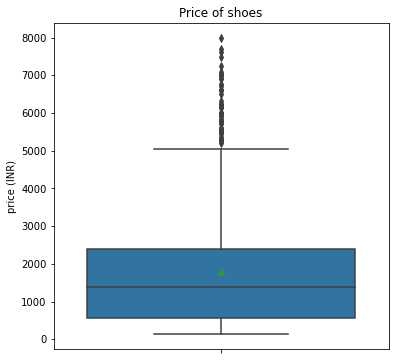

In [11]:
plt.figure(figsize=(6, 6))
sns.boxplot(y='price', data=df, showmeans=True)
plt.title('Price of shoes')
plt.ylabel('price (INR)')

Среднее значение составляет около 2000 рупий, при этом имеется ряд выбросов -- моделей, цена на которые превышает 6000 рупий. Интересно посмотреть и на взаимосвязь цены обуви и того, для кого она предназначена (женщин или мужчин).

Text(0.5, 0, 'shoe type')

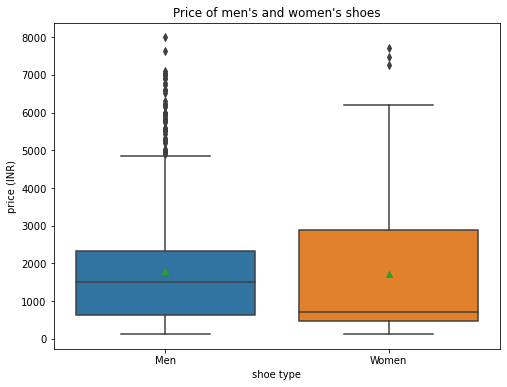

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='shoe_type', y='price', data=df, showmeans=True)
plt.title('Price of men\'s and women\'s shoes')
plt.ylabel('price (INR)')
plt.xlabel('shoe type')

Видно, что цены на женскую обувь варьируются больше, чем на мужскую, однако медианные значения достаточно близки. Выбросы наблюдаются в основном в категории мужской обуви. Интересно, что женская обувь в среднем дороже мужской (pink tax вошел в чат). Вывод -- пол потенциального покупателя имеет смысл учитывать при обучении.

Еще хочется посмотреть, есть ли взаимосвязь цены с разными параметрами описания, например, длиной (пока в токенах). Добавим колонку "desc_length".

In [13]:
descriptions = df['product_description'].tolist()

desc_lengths = []
for desc in descriptions:
    desc_lengths.append(len(desc.split()))

df['desc_length'] = desc_lengths

Посмотрим на распределение длин описаний:

Text(0, 0.5, 'number of tokens')

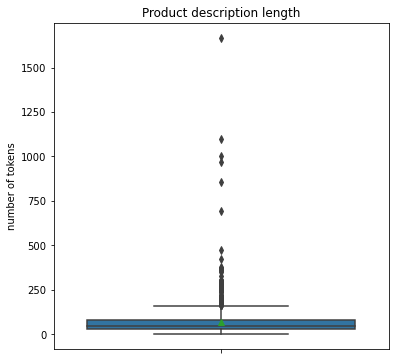

In [14]:
plt.figure(figsize=(6, 6))
sns.boxplot(y='desc_length', data=df, showmeans=True)
plt.title('Product description length')
plt.ylabel('number of tokens')

Красивое)) Попробуем убрать выбросы.

Text(0, 0.5, 'number of tokens')

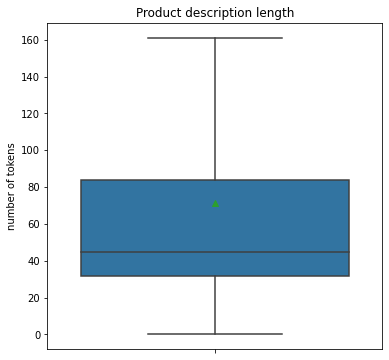

In [15]:
plt.figure(figsize=(6, 6))
sns.boxplot(y='desc_length', data=df, showmeans=True, showfliers=False)
plt.title('Product description length')
plt.ylabel('number of tokens')

Уже лучше! Теперь посмотрим, есть ли зависимость между длиной описания и ценой пары обуви.

Text(0, 0.5, 'price (INR)')

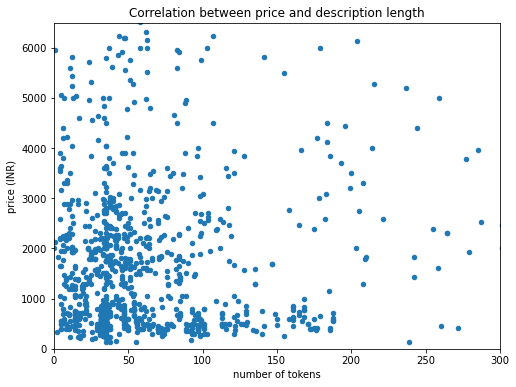

In [16]:
df.plot(kind='scatter', x='desc_length', y='price', figsize=(8, 6))
# ограничения по осям такие, чтобы обрезать не все, а самые редкие выбросы
plt.xlim(0, 300)
plt.ylim(0, 6500)
plt.title('Correlation between price and description length')
plt.xlabel('number of tokens')
plt.ylabel('price (INR)')

Не похоже, что есть прямая зависимость. Это, в общем-то, было ожидаемо (хотя в идеальном мире можно представить ситуацию, когда более дорогие бренды пишут более подробные описания товаров ~~маркетологи же должны как-то отрабатывать своб зарплату~~, а более дешевые не прилагают столько усилий; или наоборот, дорогие бренды ограничиваются парой слов, считая, что не нуждаются в представлении, а более дешевые расписывают все преимущества их продукта).

Посмотрим на описания более пристально. Во-первых, все ли они на английском языке? Для определения языка воспользуемся модулем langid. Он работает быстрее langdetect (в нашей "игрушечной" задаче это почти незаметно, но уже в следующем пункте при работе с отзывами скорость будет существенна). Существенный минус -- langid не умеет предсказывать несколько языков с разной степенью вероятности, но сейчас это не очень важно: мы не будем обучать модель на данных о языке, а просто посмотрим, что есть в нашем датасете.

In [17]:
langs = OrderedDict()
for i, desc in enumerate(tqdm(descriptions)):
    langs[i] = identifier.classify(desc)[0]

  0%|          | 0/1015 [00:00<?, ?it/s]

In [18]:
lang_counter = Counter(list(langs.values()))
lang_counter.most_common()

[('en', 980),
 ('ml', 17),
 ('pt', 6),
 ('it', 4),
 ('no', 4),
 ('ca', 1),
 ('te', 1),
 ('he', 1),
 ('nl', 1)]

Скорее всего, все языки, к которым было отнесено от 1 до 6 описаний, были определены неправильно (обычно такое бывает, когда описание очень короткое, всего из пары слов, особенно если эти слова -- какие-л. имена собственные). Выведем по одному описанию на каждом из таких языков и проверим это предположение.

In [19]:
check_langs = [(langs[desc], descriptions[desc])
               for desc in langs if langs[desc] != 'en']

random.sample(check_langs, 5)

[('ml',
  'WOMENS_NIKE SPORTSWEAR_WMNS NIKE AIR MAX EXCEE_WASHED CORAL/BLACK-WHITE_CD5432-600_10.5 UK_– Nike shoes are lightweight and durable – Despite provides exceptional comfort flexibility of Nike shoes are very light. If you buy a pair of Nike shoes for specific sports you will definitely reap the benefits for a long time.______WOMENS_NIKE SPORTSWEAR_WMNS NIKE AIR MAX എക്സ്\u200dസിറ്റ്_വാഷിംഗ് കോറോ/ബ്ലാക്ക്-വൈറ്റ്_CD5432-600_10.5 UK_– Nike ഷൂസ് ഭാരം കുറഞ്ഞതും ഈടുനിൽക്കുന്നതുമാണ് - Despite അസാധാരണമായ സുഖവും വഴക്കവും നൽകുന്നു Nike ഷൂസിന്റെ വളരെ ഭാരം കുറഞ്ഞവയാണ്. പ്രത്യേക സ്പോർട്സിനായി ഒരു ജോടി Nike ഷൂസ് വാങ്ങുകയാണെങ്കിൽ നിങ്ങൾ തീർച്ചയായും വളരെക്കാലം അതിന്\u200dറെ ഗുണങ്ങൾ മറുപടി നൽകും.'),
 ('ml',
  "SKECHERS రిలాక్స్డ్ ఫిట్తో సులభంగా ధరించే సౌకర్యంతో ప్రకాశవంతమైన వేసవి ఎండ లాగా ప్రకాశిస్తుంది: గ్రానోలా - బ్లూమ్ ఫార్మ్ శాండల్. సాధారణ సౌకర్యంలో మృదువైన మెటాలిక్-ఫినిష్ సింథటిక్ అప్పర్ క్లాసిక్ లుక్ సర్దుబాటు చేయగల బకిల్స్ మరియు Luxe ఫోమ్ ఫుట్బెడ్తో రెండు స్ట్రాప్ స్లైడ్ శాండల్. నిర్మాణ

Действительно, мы имеем дело либо с описаниями на нескольких языках (в т.ч. английском), либо с английскими описаниями, которые были распознаны как-то иначе из-за присутствующих имен собственных и других редких слов (в этот случайный набор они не попали, но я проверяла все элементы).

Из-за таких неоднородных текстов распознавание довольно неточное; чтобы использовать язык описания как фичу при обучении, пришлось бы вручную разметить данные (делать я этого, конечно же, не буду).

В принципе, уже понятно, что получилось, но нарисуем график. Объединим редкие языки в одну категорию.

In [20]:
lang_dict = {}
other = 0
for lg in list(lang_counter.keys()):
    if lang_counter[lg] > 10:
        lang_dict[lg] = lang_counter[lg]
    else:
        other += lang_counter[lg]
lang_dict['other'] = other

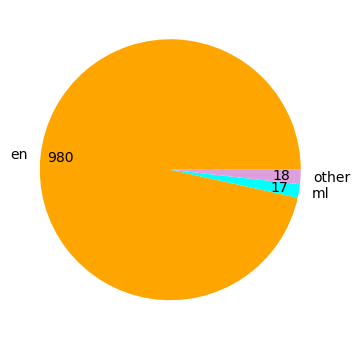

In [21]:
plt.figure(figsize=(6, 6))
plt.pie(lang_dict.values(),
        labels=lang_dict.keys(),
        autopct=lambda p: '{:.0f}'.format(p / 100 * sum(lang_dict.values())),
        textprops={'fontsize': 14},
        pctdistance=0.85,
        colors=['orange', 'cyan', 'plum'])
plt.show()

Напоследок посмотрим на статистику по всем числовым колонкам, вдруг заметим что-то интересное.

In [22]:
df.describe().round(3)

,price,rating,total_reviews,desc_length
count,1015.000,1015.000,1015.000,1015.000
mean,1789.547,3.941,783.252,71.210
std,1564.919,0.426,3034.055,100.217
min,127.000,1.000,1.000,0.000
25%,569.000,3.800,27.000,32.000
50%,1399.000,4.000,123.000,45.000
75%,2403.500,4.200,455.500,84.000
max,7992.000,5.000,42193.000,1666.000


Замеченное интересное -- в колонке с длиной описаний: минимальное значение 0, значит, есть товары совсем без описания. Посмотрим, сколько таких.

In [23]:
no_desc = []
for i, length in enumerate(desc_lengths):
    if length == 0:
        no_desc.append(i)

len(no_desc)

1

Всего один случай, супер! Выбросим его из датафрейма (ведь мы хотим предсказывать цену по описанию, а тут описания нет). Поскольку эта строка может пригодиться для второго задания, создадим копию датафрейма.

In [24]:
df1 = df.drop(no_desc[0])
df1.reset_index(drop=True, inplace=True)

#### 2. Подготовка данных (часть 2)
Выбросить лишнее и дубли, предобработать тексты.

Итак, мы нашли дубли и одну "плохую" строку -- ту, где не было описания, -- и все это удалили; привели числовые данные в числовой формат; добавили колонку с длиной описания. Перейдем к препроцессингу описаний.

Основная проблема, как выяснилось раньше, заключается в наличии описаний на нескольких языках сразу. При этом просто выкинуть описания, которые langid определил как не английские, не получится: не все "смешанные" описания распознались как тексты на других языках, где-то английский перевесил. К счастью, в нашем датасете все такие языки используют не латинскую письменность. Значит, мусор можно относительно легко удалить, не выбрасывая целые строки из датафрейма.

Заодно уберем пунктуацию: она не уникальна для большинства текстов и, скорее всего, бесполезна. Также приведем все к нижнему регистру (сначала я хотела его оставить, чтобы всякие названия брендов сохраняли первоначальный облик, но заметила, что в некоторых описаниях все слова написаны с большой буквы, а это может сильно испортить результат).

In [25]:
descs = df1['product_description'].tolist()

In [26]:
clean_descs = []

for desc in descs:
    desc_lower = desc.lower()
    # уберет пунктуацию, эмодзи и часть не-латинских символов
    desc_no_punct = re.sub(r'[^\w\s]', ' ', desc_lower)
    # уберет оставшиеся не-латинские символы
    clean_desc = regex.sub(r'[^\p{Latin}\s\d]', ' ', desc_no_punct)
    clean_descs.append(clean_desc)

Проверяя работу регулярки, я заметила, что в выдаче есть повторяющиеся элементы. Поскольку полные дубли мы удалили в самом начале, эти случаи -- яркие примеры лени маркетологов)) которые пишут одинаковые описания ко всем похожим товарам. Не исключено, что у таких пар обуви и цена будет одинаковой (например, если они отличаются только цветом). Но удалять такие данные не очень хочется: они могут различаться по ряду других параметров, и лучше учесть эти параметры, а не выбрасывать элементы.

In [27]:
Counter(clean_descs).most_common(3)

[('the product will be an excellent pick for you  it ensures an easy maintenance ',
  27),
 ('experience great comfort walking in this pair of formal shoes from the house of hush puppies featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade ',
  20),
 ('perfect to rev up your sporty spirit this trendy pair of sports shoes from the house of power provides excellent durability and ensures sturdy grip  designed to keep feet relaxed with a soft and comfortable fit this stylish yet functional pair ensures flexibility and freedom of movement with responsive cushioning and enhanced lightweight feel ',
  11)]

Переходим к лемматизации. Для этого я выбрала UDPipe -- он очень быстрый и довольно точный. (Параллельно удаляем стоп-слова -- они тоже будут неуникальными и не дадут полезной информации.)

In [28]:
lemmatized_descs = []
blacklist = stopwords.words('english')

for desc in tqdm(clean_descs):
    doc = nlp(desc)
    lemmas = [token.lemma_ for token in doc
              if token.lemma_ not in blacklist]
    lemmatized_descs.append(' '.join(lemmas))

  0%|          | 0/1014 [00:00<?, ?it/s]

In [29]:
df1['desc_lemmas'] = lemmatized_descs
df1.drop(columns=['title',
                  'total_reviews',
                  'reviews',
                  'reviews_rating',
                  'desc_length',
                  'product_description'], inplace=True)
df1.rename(columns={'price': 'shoe_price',
                    'rating': 'shoe_rating'}, inplace=True)
df1

,shoe_price,shoe_rating,shoe_type,desc_lemmas
0,279.0,2.9,Men,elevate style classy pair run shoe house clymb...
1,479.0,3.9,Men,product excellent pick ensure easy maintenance
2,430.0,3.3,Men,flaunt stylish unique red casual shoe per late...
3,499.0,4.2,Men,robbie jone shoe design keep mind durability w...
4,499.0,4.2,Men,sparx spectacular range footwear house relaxo ...
...,...,...,...,...
1009,7256.0,4.4,Women,nike react vision story surreal comfort layer ...
1010,5822.0,4.3,Women,benefit g limitless puma 's key style new seas...
1011,5362.0,4.5,Women,lead pack new balance 's echolucent sneaker sn...
1012,7480.0,4.5,Women,nike 5 k nike woman 's run shoe feel even look...


#### 3. Векторизация

**CountVectorizer (Bag of Words)**

In [30]:
cv1 = CountVectorizer(max_features=1000)
X1 = cv1.fit_transform(lemmatized_descs)

count_matrix1 = X1.toarray()
cv_feature_names1 = cv1.get_feature_names()

In [31]:
count_df1 = pd.DataFrame(count_matrix1, columns=cv_feature_names1)
count_df1 = pd.merge(df1, count_df1, left_index=True, right_index=True)
count_df1.drop('desc_lemmas', axis=1, inplace=True)

**TfIdfVectorizer**

In [32]:
tiv1 = TfidfVectorizer(max_features=1000)
Y1 = tiv1.fit_transform(lemmatized_descs)

tfidf_matrix1 = Y1.toarray()
tiv_feature_names1 = tiv1.get_feature_names()

In [33]:
tfidf_df1 = pd.DataFrame(tfidf_matrix1, columns=tiv_feature_names1)
tfidf_df1 = pd.merge(df1, tfidf_df1, left_index=True, right_index=True)
tfidf_df1.drop('desc_lemmas', axis=1, inplace=True)

#### 4. Гридсерч
1. Три вида моделей на данных, векторизованных CountVectorizer:

In [34]:
cv_x1 = count_df1.drop(columns=['shoe_rating',
                                'shoe_type',
                                'shoe_price'], axis=1).values
cv_y1 = count_df1['shoe_price'].values

x_train1, x_test1, y_train1, y_test1 = train_test_split(
    cv_x1, cv_y1, random_state=0)

In [41]:
# Обычная линейная регрессия

lin_reg = LinearRegression()

linreg_params = {'fit_intercept': [True, False],
                 'normalize': [True, False],
                 'positive': [True, False]
                 }

grid_search = GridSearchCV(lin_reg,
                           param_grid=linreg_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -916.0978179870517
Best parameters: {'fit_intercept': False, 'normalize': True, 'positive': True}


In [36]:
# Ридж

ridge_model = Ridge()

ridge_params = {'alpha': [0.05, 0.1, 0.15, 0.5, 1, 2],
                'fit_intercept': [True, False],
                'normalize': [True, False],
                'solver': ['auto', 'svd', 'cholesky',
                           'lsqr', 'sparse_cg', 'saga'],
                'random_state': [0]
                }

grid_search = GridSearchCV(ridge_model,
                           param_grid=ridge_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -798.1044613665867
Best parameters: {'alpha': 1, 'fit_intercept': True, 'normalize': True, 'random_state': 0, 'solver': 'saga'}


In [37]:
# Лассо

lasso_model = Lasso()

lasso_params = {'alpha': [0.01, 0.05, 0.1, 0.15, 0.5, 1],
                'fit_intercept': [True, False],
                'normalize': [True, False],
                'random_state': [0],
                'selection': ['cyclic', 'random']}

grid_search = GridSearchCV(lasso_model,
                           param_grid=lasso_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -826.5027116452948
Best parameters: {'alpha': 1, 'fit_intercept': True, 'normalize': True, 'random_state': 0, 'selection': 'cyclic'}


2. Те же модели, обученные на данных от TfIdfVectorizer:

In [38]:
tiv_x1 = tfidf_df1.drop(columns=['shoe_rating',
                                 'shoe_type',
                                 'shoe_price'], axis=1).values
tiv_y1 = tfidf_df1['shoe_price'].values

x_train1, x_test1, y_train1, y_test1 = train_test_split(
    tiv_x1, tiv_y1, random_state=0)

In [45]:
# Обычная линейная регрессия

lin_reg = LinearRegression()

linreg_params = {'fit_intercept': [True, False],
                 'normalize': [True, False],
                 'positive': [True, False]
                 }

grid_search = GridSearchCV(lin_reg,
                           param_grid=linreg_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -916.0978179870517
Best parameters: {'fit_intercept': False, 'normalize': True, 'positive': True}


In [42]:
# Ридж

ridge_model = Ridge()

ridge_params = {'alpha': [0.01, 0.05, 0.1, 0.15, 0.5, 1],
                'fit_intercept': [True, False],
                'normalize': [True, False],
                'solver': ['auto', 'svd', 'cholesky',
                           'lsqr', 'sparse_cg', 'saga'],
                'random_state': [0]
                }

grid_search = GridSearchCV(ridge_model,
                           param_grid=ridge_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -737.6953214998861
Best parameters: {'alpha': 0.5, 'fit_intercept': True, 'normalize': False, 'random_state': 0, 'solver': 'lsqr'}


In [43]:
# Лассо

lasso_model = Lasso()

lasso_params = {'alpha': [0.01, 0.05, 0.1, 0.15, 0.5, 1],
                'fit_intercept': [True, False],
                'normalize': [True, False],
                'random_state': [0],
                'selection': ['cyclic', 'random']}

grid_search = GridSearchCV(lasso_model,
                           param_grid=lasso_params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(x_train1, y_train1)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -756.4750041400223
Best parameters: {'alpha': 1, 'fit_intercept': True, 'normalize': False, 'random_state': 0, 'selection': 'random'}


Итак, лучшая модель -- Ridge, обученная на данных, векторизованных TfIdf. Почему так получилось? Ну, во-первых, сам алгоритм TfIdf "умнее" -- он учитывает не только частотность, но и "важность", специфичность слова.
Что касается разницы между Ridge и Lasso, она не слишком большая, но интересно, что Лассо хуже (казалось бы, на таком количестве колонок умение занулять коэффициенты при ненужных фичах должно было повысить точность, а не понизить). Вероятно, сказалось ограничение на количество фич при векторизации (и при большем их числе было бы больше нулей -- тут-то и пригодилось бы зануление коэффициентов).

#### 5. Оценка качества и анализ

In [46]:
best_model = Ridge(alpha=0.5, fit_intercept=True,
                   normalize=False, random_state=0, solver='lsqr')
best_model.fit(x_train1, y_train1)
preds1 = best_model.predict(x_test1)

In [47]:
mean_absolute_error(y_test1, preds1)

765.8217853364768

Визуализируем результат.

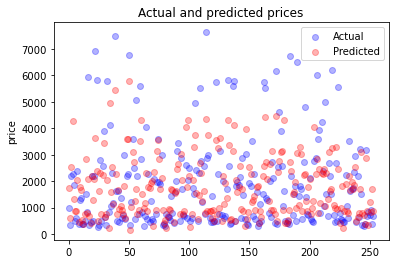

In [53]:
_, ax = plt.subplots()

ax.scatter(x=range(0, y_test1.size), y=y_test1,
           c='blue', label='Actual', alpha=0.3)
ax.scatter(x=range(0, preds1.size), y=preds1,
           c='red', label='Predicted', alpha=0.3)

plt.title('Actual and predicted prices')
plt.ylabel('price')
plt.legend()
plt.show()

Получилось не супер информативно (точек многовато), но в целом похоже, что более бюджетные (до 3000 рупий) модели предсказываются лучше, чем дорогие. С выбросами (>6000) наша модель вообще не справляется, что не очень-то удивительно -- на то они и выбросы.

Что в принципе можно сделать, чтобы улучшить качество? Во-первых, не учитывать выбросы. Во-вторых, интересно проверить, поможет ли использование информации о том, для кого предназначена обувь (мужчин или женщин). Как мы выяснили, женская в среднем дороже (это отражает реальный феномен -- pink tax). Наконец, можно использовать названия обуви как текстовые фичи: они часто начинаются с названия бренда, а бренд напрямую связан с ценой (в идеале, конечно, научиться извлекать бренды из названий и использовать их как отдельную колонку в наших данных).

### Часть 2: предсказываем оценку по отзыву
#### 0. Подготовка датафрейма (предварительная)
*(как в прошлый раз, будет и нормальная)*

Часть данных мы уже подготовили в первом задании: привели колонки с числами в числовой формат и удалили дубли. Теперь посмотрим на отзывы и оценки: они склеены в одну строку для каждого товара. Важно понять, как мы хотим решать стоящую перед нами задачу, -- предсказывать среднюю оценку товара по оставленным на него отзывам или предсказывать оценку одного человека по его отзыву. Мне кажется более логичным второй вариант. Во-первых, взаимосвязь между отзывом и оценкой одного человека более конкретная: редко бывает, что человек ругает товар последними словами, а потом ставит ему высшую оценку. В усредненном виде, однако, эта взаимосвязь нарушается, потому что всегда есть очень довольные и очень недовольные покупатели. Еще одна проблема заключается в наших данных: на некоторые товары меньше 5 отзывов, на некоторые -- несколько тысяч. Это очень усложняет предсказание оценки товара по всему массиву отзывов.

Разделим склеенные отзывы и оценки пользователей на отдельные строки. Для этого превратим строковые данные в списки и применим pd.Series.explode (кажется, она хуже df.explode() в терминах производельности, но df.explode() на двух колонках работает неправильно, хотя в совпадении длин списков я уверена -- проверяла).

In [54]:
reviews = df['reviews'].tolist()
split_reviews = [one_prod.split('|| ') for one_prod in reviews]
df['reviews'] = split_reviews

user_ratings = df['reviews_rating'].tolist()
split_ratings = [one_prod.split('|| ') for one_prod in user_ratings]
df['reviews_rating'] = split_ratings

In [55]:
df2 = df.apply(pd.Series.explode)
df2.reset_index(drop=True, inplace=True)
df2

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,shoe_type,desc_length
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,Not happy with product,1.0 out of 5 stars,Men,35
1,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,It's not as expected.,1.0 out of 5 stars,Men,35
2,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,AVERAGE PRODUCT,3.0 out of 5 stars,Men,35
3,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,Pic more beautiful,3.0 out of 5 stars,Men,35
4,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,Got damage product. But quality is average for...,3.0 out of 5 stars,Men,35
...,...,...,...,...,...,...,...,...,...
8203,ASICS Women Gt-2000 7 Lite-Show Running Shoes,5719.0,4.1,210,The GT-2000 7 achieves a reassuringly firm rid...,Go for it!,5.0 out of 5 stars,Women,24
8204,ASICS Women Gt-2000 7 Lite-Show Running Shoes,5719.0,4.1,210,The GT-2000 7 achieves a reassuringly firm rid...,Excellent product,5.0 out of 5 stars,Women,24
8205,ASICS Women Gt-2000 7 Lite-Show Running Shoes,5719.0,4.1,210,The GT-2000 7 achieves a reassuringly firm rid...,Nice shoe,5.0 out of 5 stars,Women,24
8206,ASICS Women Gt-2000 7 Lite-Show Running Shoes,5719.0,4.1,210,The GT-2000 7 achieves a reassuringly firm rid...,Nice,5.0 out of 5 stars,Women,24


Теперь можно еще раз выбросить дубли. В отличие от прошлого задания, где дублирующиеся описания были виной производителя, а не автора данных, здесь ситуация иная: отзывы могут дублироваться в результате сбоя в системе или человеческого фактора (человек два раза оставил отзыв, потому что не понял, отправился ли он в первый раз).

In [56]:
len(df2[df2.duplicated()])

346

In [57]:
df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True, inplace=True)

Колонку "reviews_rating" имеет смысл превратить в числа, как мы это делали в первом задании с "rating".

In [63]:
sep_ratings = [int(float(r.split()[0]))
               for r in df2['reviews_rating'].tolist()]
df2['reviews_rating'] = sep_ratings

#### 1. Анализ данных
Перейдем к анализу. Посмотрим, сколько у нас отзывов каждого типа.

In [64]:
stars = df2['reviews_rating'].tolist()
rating_counter = Counter(stars)

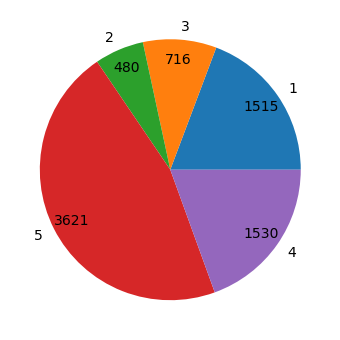

In [65]:
plt.figure(figsize=(6, 6))
plt.pie(rating_counter.values(),
        labels=rating_counter.keys(),
        autopct=lambda p: '{:.0f}'.format(
            p / 100 * sum(rating_counter.values())),
        textprops={'fontsize': 14},
        pctdistance=0.85)
plt.show()

Больше всего очень положительных отзывов (5 звезд), много очень отрицательных (1 звезда); отзывов с рейтингом 4 примерно столько же, сколько отрицательных. Неприятно, что есть два относительно маленьких класса -- 2 и 3 звезды. (Понятно, что это задача классификации, а не регрессии, раз у нас есть 5 четких классов.)

Теперь посмотрим на сами отзывы -- длину и язык.

In [66]:
reviews = df2['reviews'].tolist()

rev_lengths = []
for rev in reviews:
    rev_lengths.append(len(rev.split()))

df2['rev_length'] = rev_lengths

Text(0, 0.5, 'number of tokens')

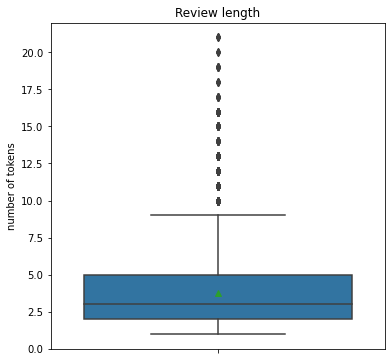

In [67]:
plt.figure(figsize=(6, 6))
sns.boxplot(y='rev_length', data=df2, showmeans=True)
plt.title('Review length')
plt.ylabel('number of tokens')

Мда)) такая маленькая длина отзыва, скорее всего, окажется недостаточной для точного предсказания.

Попытаем счастья -- есть ли зависимость между длиной отзыва и оценкой? Может быть, недовольные клиенты пишут полотно текста, а довольные ограничиваются парой хороших слов?

Text(0, 0.5, 'rating (out of 5 stars)')

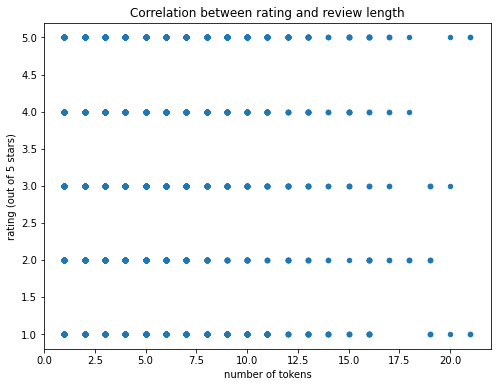

In [68]:
df2.plot(kind='scatter', x='rev_length', y='reviews_rating', figsize=(8, 6))
plt.title('Correlation between rating and review length')
plt.xlabel('number of tokens')
plt.ylabel('rating (out of 5 stars)')

Не повезло, но этого следовало ожидать. Посмотрим теперь на языки отзывов.

In [69]:
rev_langs = OrderedDict()
for i, rev in enumerate(tqdm(reviews)):
    rev_langs[i] = identifier.classify(rev)[0]

  0%|          | 0/7862 [00:00<?, ?it/s]

In [70]:
rev_lang_counter = Counter(list(rev_langs.values()))
rev_lang_counter.most_common()

[('en', 6832),
 ('es', 168),
 ('fr', 125),
 ('de', 119),
 ('it', 100),
 ('pt', 69),
 ('nl', 59),
 ('ja', 46),
 ('zh', 42),
 ('da', 36),
 ('et', 25),
 ('fi', 21),
 ('ko', 17),
 ('hr', 17),
 ('sv', 15),
 ('ca', 14),
 ('ro', 12),
 ('am', 10),
 ('hi', 9),
 ('pl', 9),
 ('sl', 8),
 ('cs', 8),
 ('id', 6),
 ('la', 6),
 ('mr', 6),
 ('lt', 6),
 ('tl', 5),
 ('no', 5),
 ('ne', 5),
 ('ar', 5),
 ('ms', 4),
 ('he', 4),
 ('cy', 4),
 ('hu', 4),
 ('vi', 4),
 ('lv', 4),
 ('nb', 3),
 ('km', 3),
 ('mg', 3),
 ('sw', 3),
 ('af', 3),
 ('eu', 3),
 ('mt', 2),
 ('ml', 2),
 ('ta', 2),
 ('el', 1),
 ('bn', 1),
 ('gl', 1),
 ('sq', 1),
 ('vo', 1),
 ('fo', 1),
 ('rw', 1),
 ('dz', 1),
 ('gu', 1)]

Ого! Разнообразие гораздо больше, чем в случае с описаниями. Впрочем, наверняка есть и мусор. Видно, что есть редкие языки, причем отчасти совпадающие с теми, что мы видели в первой части. При этом значительное большинство отзывов распределились по европейским языкам. Попробуем пока оставить как есть и вернуться к этому вопросу после препроцессинга.

Посмотрим, наконец, на статистику по датафрейму.

In [71]:
df2.describe().round(3)

,price,rating,total_reviews,reviews_rating,desc_length,rev_length
count,7862.000,7862.000,7862.000,7862.000,7862.000,7862.000
mean,1604.955,3.946,978.818,3.669,68.340,3.762
std,1363.109,0.338,3354.074,1.556,88.426,2.856
min,127.000,1.000,1.000,1.000,0.000,1.000
25%,559.000,3.800,66.000,2.000,32.000,2.000
50%,1259.000,4.000,217.000,4.000,42.000,3.000
75%,2199.000,4.100,666.000,5.000,82.000,5.000
max,7992.000,5.000,42193.000,5.000,1666.000,21.000


Важно, что отзывов с нулевой длиной не бывает (иначе нужно было бы удалить эти строки, как в первой части).

#### 2. Подготовка данных
Препроцессинг в целом тот же, что и в первой части, но хочется сохранить эмодзи. Еще одно отличие в том, что нужно что-то придумывать для не-английских текстов.

In [72]:
characters = [list(rev) for rev in reviews]

rev_emojis = []
for rev in characters:
    emojis = [c for c in rev if c in UNICODE_EMOJI['en']]
    rev_emojis.append(emojis)

In [73]:
clean_revs = []
for rev in reviews:
    rev_lower = rev.lower()
    # уберет пунктуацию, эмодзи и часть не-латинских символов
    rev_no_punct = re.sub(r'[^\w\s]', ' ', rev_lower)
    # уберет оставшиеся не-латинские символы
    clean_rev = regex.sub(r'[^\p{Latin}\s\d]', ' ', rev_no_punct)
    clean_revs.append(clean_rev)

In [74]:
clean_rev_langs = OrderedDict()
for i, rev in enumerate(tqdm(clean_revs)):
    clean_rev_langs[i] = identifier.classify(rev)[0]

  0%|          | 0/7862 [00:00<?, ?it/s]

In [75]:
clean_lang_counter = Counter(list(clean_rev_langs.values()))
clean_lang_counter.most_common(10)

[('en', 6998),
 ('es', 165),
 ('fr', 125),
 ('de', 120),
 ('it', 108),
 ('nl', 48),
 ('ro', 47),
 ('da', 44),
 ('et', 31),
 ('pt', 30)]

Кажется, ситуация не слишком улучшилась. Попробуем посмотреть, какие отзывы были размечены как не-английские.

In [76]:
check = [(clean_rev_langs[rv], clean_revs[rv])
         for rv in clean_rev_langs
         if clean_rev_langs[rv] != 'en']

In [77]:
random.sample(check, 10)

[('de', 'worst experience'),
 ('fr', 'nice quality'),
 ('ca', 'wrong colour shoes delivered still decent quality'),
 ('es', 'good quality'),
 ('es', 'excellent model '),
 ('de', 'excellent   shoe'),
 ('es', 'cheap quality'),
 ('de', 'excellent'),
 ('es', 'honest review  '),
 ('sv', 'so hard bottom sole     ')]

Действительно, это просто неверное определение языка (я, конечно, просмотрела куда больше 10 описаний, и действительно попадаются иностранные, но чаще с примесью английского, так что можно их не выбрасывать).

Лемматизируем наши данные.

In [78]:
lemmatized_revs = []
blacklist = stopwords.words('english')

for rev in tqdm(clean_revs):
    doc = nlp(rev)
    lemmas = [token.lemma_ for token in doc
              if token.lemma_ not in blacklist]
    lemmatized_revs.append(' '.join(lemmas))

  0%|          | 0/7862 [00:00<?, ?it/s]

Теперь добавим к нашим данным эмодзи (пока мы используем CountVectorizer и TfIdfVectorizer, нам не важно, что сбивается порядок). Заодно создадим список has_emoji, в котором укажем, есть ли в очередном сообщении смайлики (это может помочь при обучении, т.к. сами смайлики могут не пройти порог при векторизации).

In [79]:
has_emoji = []
with_emoji = []
for i, rev in enumerate(lemmatized_revs):
    emojis = ' '.join(rev_emojis[i])
    full_rev = rev + ' ' + emojis
    with_emoji.append(full_rev)
    if emojis:
        has_emoji.append(1)
    else:
        has_emoji.append(0)

In [80]:
df2['has_emoji'] = has_emoji
df2['rev_lemmas'] = with_emoji

df2.drop(columns=['title',
                  'price',
                  'rating',
                  'total_reviews',
                  'desc_length',
                  'product_description',
                  'shoe_type',
                  'rev_length',
                  'reviews'], inplace=True)

df2

,reviews_rating,has_emoji,rev_lemmas
0,1,0,happy product
1,1,0,expect
2,3,0,average product
3,3,0,pic beautiful
4,3,0,get damage product quality average 300
...,...,...,...
7857,5,0,go
7858,5,0,excellent product
7859,5,0,nice shoe
7860,5,0,nice


#### 3. Векторизация

**CountVectorizer (Bag of Words)**

In [81]:
rev_lemmas = df2['rev_lemmas'].tolist()

In [82]:
cv2 = CountVectorizer(max_features=2000)
X2 = cv2.fit_transform(rev_lemmas)

count_matrix2 = X2.toarray()
cv_feature_names2 = cv2.get_feature_names()

In [83]:
count_df2 = pd.DataFrame(count_matrix2, columns=cv_feature_names2)
count_df2 = pd.merge(df2, count_df2, left_index=True, right_index=True)
count_df2.drop('rev_lemmas', axis=1, inplace=True)

**TfIdfVectorizer**

In [84]:
tiv2 = TfidfVectorizer(max_features=2000)
Y2 = tiv2.fit_transform(rev_lemmas)

tfidf_matrix2 = Y2.toarray()
tiv_feature_names2 = tiv2.get_feature_names()

In [85]:
tfidf_df2 = pd.DataFrame(tfidf_matrix2, columns=tiv_feature_names2)
tfidf_df2 = pd.merge(df2, tfidf_df2, left_index=True, right_index=True)
tfidf_df2.drop('rev_lemmas', axis=1, inplace=True)

#### 4. Гридсерч
1. Три вида моделей на данных, векторизованных CountVectorizer:

In [87]:
cv_x2 = count_df2.drop(columns=['reviews_rating', 'has_emoji'], axis=1).values
cv_y2 = count_df2['reviews_rating'].values

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    cv_x2, cv_y2, random_state=0)

In [88]:
# Мультиномиальный Байес

mnb = MultinomialNB()

mnb_params = {'alpha': [0.1, 0.5, 1.0, 1.5]}

mnb_cv = GridSearchCV(mnb,
                      param_grid=mnb_params,
                      cv=5,
                      n_jobs=-1)

mnb_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(mnb_cv.best_score_))
print('Best parameters: {}'.format(mnb_cv.best_params_))

Тут у меня слетели принты(( лечится только перезапусканием тетрадки, так что придется обойтись.

In [107]:
'Best score: {}'.format(mnb_cv.best_score_)

'Best score: 0.5934543781716767'

In [108]:
'Best parameters: {}'.format(mnb_cv.best_params_)

"Best parameters: {'alpha': 0.5}"

In [89]:
# Логистическая регрессия

logreg = LogisticRegression()

logreg_params = {'C': [0.1, 0.5, 1.0, 1.5],
                 'fit_intercept': [True, False],
                 'class_weight': ['balanced', None],
                 'random_state': [0]}

logreg_cv = GridSearchCV(logreg,
                         param_grid=logreg_params,
                         cv=5,
                         n_jobs=-1)

logreg_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(logreg_cv.best_score_))
print('Best parameters: {}'.format(logreg_cv.best_params_))

In [91]:
'Best score: {}'.format(logreg_cv.best_score_)

'Best score: 0.5993920443926912'

In [92]:
'Best parameters: {}'.format(logreg_cv.best_params_)

"Best parameters: {'C': 1.0, 'class_weight': None, 'fit_intercept': True, 'random_state': 0}"

In [93]:
# Linear SVC

lin_svc = LinearSVC()

linsvc_params = {'loss': ['hinge', 'squared_hinge'],
                 'C': [0.05, 0.1, 0.5, 1.0],
                 'multi_class': ['ovr', 'crammer_singer'],
                 'class_weight': ['balanced', None],
                 'random_state': [0]}

linsvc_cv = GridSearchCV(lin_svc,
                         param_grid=linsvc_params,
                         cv=5,
                         n_jobs=-1)

linsvc_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(linsvc_cv.best_score_))
print('Best parameters: {}'.format(linsvc_cv.best_params_))

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 0.5, 1.0],
                         'class_weight': ['balanced', None],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'random_state': [0]})

In [94]:
'Best score: {}'.format(linsvc_cv.best_score_)

'Best score: 0.5966771610528888'

In [95]:
'Best parameters: {}'.format(linsvc_cv.best_params_)

"Best parameters: {'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'random_state': 0}"

2. То же для данных, векторизованных TfIdf Vectorizer:

In [96]:
tiv_x2 = tfidf_df2.drop(columns=['reviews_rating', 'has_emoji'], axis=1).values
tiv_y2 = tfidf_df2['reviews_rating'].values

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    tiv_x2, tiv_y2, random_state=0)

In [97]:
# Мультиномиальный Байес

mnb = MultinomialNB()

mnb_params = {'alpha': [0.1, 0.5, 1.0, 1.5]}

mnb_cv = GridSearchCV(mnb,
                      param_grid=mnb_params,
                      cv=5,
                      n_jobs=-1)

mnb_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(mnb_cv.best_score_))
print('Best parameters: {}'.format(mnb_cv.best_params_))

In [98]:
'Best score: {}'.format(mnb_cv.best_score_)

'Best score: 0.5934543781716767'

In [99]:
'Best parameters: {}'.format(mnb_cv.best_params_)

"Best parameters: {'alpha': 0.5}"

In [100]:
# Логистическая регрессия

logreg = LogisticRegression()

logreg_params = {'C': [0.5, 1.0, 1.5, 2.0],
                 'fit_intercept': [True, False],
                 'class_weight': ['balanced', None],
                 'random_state': [0]}

logreg_cv = GridSearchCV(logreg,
                         param_grid=logreg_params,
                         cv=5,
                         n_jobs=-1)

logreg_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(logreg_cv.best_score_))
print('Best parameters: {}'.format(logreg_cv.best_params_))

In [101]:
'Best score: {}'.format(logreg_cv.best_score_)

'Best score: 0.5992212590388293'

In [103]:
'Best parameters: {}'.format(logreg_cv.best_params_)

"Best parameters: {'C': 2.0, 'class_weight': None, 'fit_intercept': True, 'random_state': 0}"

In [104]:
# Linear SVC

lin_svc = LinearSVC()

linsvc_params = {'loss': ['hinge', 'squared_hinge'],
                 'C': [0.05, 0.1, 0.5, 1.0],
                 'multi_class': ['ovr', 'crammer_singer'],
                 'class_weight': ['balanced', None],
                 'random_state': [0]}

linsvc_cv = GridSearchCV(lin_svc,
                         param_grid=linsvc_params,
                         cv=5,
                         n_jobs=-1)

linsvc_cv.fit(x_train2, y_train2)

print('Best score: {}'.format(linsvc_cv.best_score_))
print('Best parameters: {}'.format(linsvc_cv.best_params_))

In [105]:
'Best score: {}'.format(linsvc_cv.best_score_)

'Best score: 0.5931142450511062'

In [106]:
'Best parameters: {}'.format(linsvc_cv.best_params_)

"Best parameters: {'C': 0.5, 'class_weight': None, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'random_state': 0}"

Итак, лучшая модель -- логистическая регрессия. Странно, что на данных, векторизованных CountVectorizer, она сработала лучше, пусть и незначительно (0.5993920443926912 -- но у меня как-то получалось 0.603 с чем-то, сейчас не воспроизведу). **Спойлер:** ниже я обучила эту модель на обоих датасетах с подобранными параметрами и получила лучший результат с TfIdf векторайзером, так что тут влияет элемент случайности).

Учитывая, с какими данными пришлось работать моделям, сложно с уверенностью сказать, почему именно логистическая регрессия оказалась более эффективной. Понятно, что мультиномиальный Байес сработал хуже -- это довольно простой алгоритм. 

#### 5. Оценка качества и анализ

In [116]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    cv_x2, cv_y2, random_state=0)

best_class_model = LogisticRegression(
    C=1.0, class_weight=None, fit_intercept=True, random_state=0)
best_class_model.fit(x_train2, y_train2)
preds2 = best_class_model.predict(x_test2)

In [ ]:
acc = accuracy_score(preds2, y_test2)

In [130]:
'acc={0:1.4f}'.format(acc)

'acc=0.5738'

Вот это уже неприятно. Попробуем эту же модель на данных, векторизованных TfIdf (по логике она должна работать лучше, результаты были очень близки).

In [134]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(
    tiv_x2, tiv_y2, random_state=0)

tiv_class_model = LogisticRegression(
    C=1.0, class_weight=None, fit_intercept=True, random_state=0)
tiv_class_model.fit(x_train3, y_train3)
preds3 = best_class_model.predict(x_test3)

In [135]:
acc = accuracy_score(preds3, y_test3)

In [137]:
acc

0.5778229908443541

Разница совсем небольшая, на этот раз в пользу TfIdfVectorizer. Рассчитаем остальные метрики.

In [138]:
acc = accuracy_score(preds3, y_test3)
micro_f1 = f1_score(preds3, y_test3, average='micro')
micro_p = precision_score(preds3, y_test3, average='micro')
micro_r = recall_score(preds3, y_test3, average='micro')
macro_f1 = f1_score(preds3, y_test3, average='macro')
macro_p = precision_score(preds3, y_test3, average='macro')
macro_r = recall_score(preds3, y_test3, average='macro')

In [139]:
'micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(
    micro_f1, micro_p, micro_r)

'micro F1=0.5778, micro P=0.5778, micro R=0.5778'

In [140]:
'macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}'.format(
    macro_f1, macro_p, macro_r)

'macro F1=0.3342, macro P=0.3569, macro R=0.4313'

In [143]:
r2_score(preds3, y_test3)

0.091108890847717

Построим еще матрицу ошибок.

<AxesSubplot:>

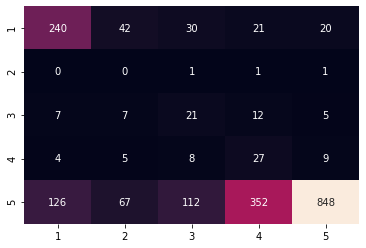

In [144]:
sns.heatmap(data=confusion_matrix(preds3, y_test3),
            annot=True, fmt='d', cbar=False,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])

Тут все довольно логично: чем крупнее класс, тем больше его элементов распознались как правильные (это особенно заметно на классе 5. Кроме того, видно, что соседние значения иногда путаются (например, отзывы с 5 звездами получают 4 звезды и т.д.). Ну и, естественно, по такой матрице понятно, что у классов ощутимый дисбаланс и все плохо (маленькие классы пресказываются хуже).

Про улучшения: во-первых, должно помочь соблюдение баланса классов (у нас очень много отзывов на 5 звезд и совсем мало на 2 и 3 звезды). Для этого можно выкинуть часть самого большого класса (но в нашем случае это плохо, датасет и так небольшой) или дублировать примеры самых маленьких классов (а лучше и то, и другое). Кроме того, можно попробовать учесть колонку "has_emoji" (сами эмоджи есть в текстах, но при векторизации легко могли отсеяться из-за ограничения на кол-во фичей). Мое предположение -- смайлики скорее есть в очень хороших и очень плохих отзывах.

Помимо всего сказанного, логистическая регрессия воспринимает все фичи как независимые, что вряд ли соответствует действительности, когда речь идет о работе с текстом. Так, какие-то слова имеют тенденцию чаще появляться вместе, т.е. появление одного увеличивает вероятность появления второго. Чтобы учесть такие моменты, имеет смысл при векторизации смотреть также на би- и триграммы.